In [1]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs

assert torch.backends.mps.is_available(), \
"The current runtime does not have MPS support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [3]:
def download_url(url, model_dir='.', overwrite=False):
    import os, sys, ssl
    from urllib.request import urlretrieve

    ssl._create_default_https_context = ssl._create_unverified_context
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)

    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir
        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write(f'Downlaoding {model_dir} {cached_file}')
            urlretrieve(url, cached_file)
        return cached_file
    except:
        # remove lock file so download can be executed next time
        os.remove(os.path.join(model_dir, 'download.lock'))
        sys.stderr.write(f'Failed to download {url}')
                  

In [4]:
class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))

    self.backbone = nn.Sequential(OrderedDict(layers))
    self.classifier = nn.Linear(512, 10)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    x = x.mean([2, 3])

    # classifier: [N, 512] => [N, 10]
    x = self.classifier(x)
    return x

In [6]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [37]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [7]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

In [8]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)

def get_sparsity(tensor: torch.Tensor) -> float:
    return 1- float(tensor.count_nonzero())/tensor.numel()

def get_model_sparsity(model: nn.Module) -> float:
    num_nonzeros, num_ele = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_ele += param.numel()
    return 1 - float(num_nonzeros/num_ele)

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements

def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [ ]:
### Define misc for verification

In [20]:
def test_fine_grained_prune(test_tensor=torch.tensor([[-0.46, -0.40, 0.39, 0.19, 0.37],
                              [0.00, 0.40, 0.17, -0.15, 0.16],
                              [-0.20, -0.23, 0.36, 0.25, 0.03],
                              [0.24, 0.41, 0.07, 0.13, -0.15],
                              [0.48, -0.09, -0.36, 0.12, 0.45]]), 
                           test_mask=torch.tensor([[True, True, False, False, False],
                            [False, True, False, False, False],
                            [False, False, False, False, False],
                            [False, True, False, False, False],
                            [True, False, False, False, True]]), 
                           target_sparsity=0.75, target_nonzeros=None):
    def plot_matrix(tensor, ax, title):
        ax.imshow(tensor.cpu().numpy() == 0, vmin=0, vmax=1, cmap='tab20c')
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for j in range(tensor.shape[1]):
            for i in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                               ha='center',va='center', color='k')
    test_tensor = test_tensor.clone()
    fig, axes = plt.subplots(1, 2, figsize=(6, 10))
    ax_left, ax_right = axes.ravel()
    plot_matrix(test_tensor, ax_left, 'dense_tensor')

    sparsity_before_pruning = get_sparsity(test_tensor)
    mask = fine_grained_prune(test_tensor, target_sparsity)
    sparsity_after_pruning = get_sparsity(test_tensor)
    sparsity_of_mask = get_sparsity(mask)

    plot_matrix(test_tensor, ax_right, 'sparse tensor')
    fig.tight_layout()
    plt.show()

    print('* Test fine_grained_prune()')
    print(f'    target sparsity: {target_sparsity:.2f}')
    print(f'        sparsity before pruning: {sparsity_before_pruning:.2f}')
    print(f'        sparsity after pruning: {sparsity_after_pruning:.2f}')
    print(f'        sparsity of pruning mask: {sparsity_of_mask:.2f}')

    if target_nonzeros is None:
        if test_mask.equal(mask):
            print('* Test passed.')
        else:
            print('* Test failed.')
    else:
        if mask.count_nonzero() == target_nonzeros:
            print('* Test passed.')
        else:
            print('* Test failed.')    
        
        

#test_fine_grained_prune()
### Load the pre-trained model and CIFAR-10 dataset

In [10]:
checkpoint_url = "https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth"
checkpoint = torch.load(download_url(checkpoint_url), map_location='cpu', weights_only=True)


model = VGG().to(device)
model.load_state_dict(checkpoint['state_dict'])
recover_model = lambda: model.load_state_dict(checkpoint['state_dict'])

In [11]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

Files already downloaded and verified
Files already downloaded and verified


### Verify the accuracy and model size

In [12]:
default_model_accuracy = evaluate(model, dataloader['test'])
default_model_size = get_model_size(model)

print(f'Model accuracy: {default_model_accuracy:.2f}, model size: {default_model_size/MiB:.2f}')

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Model accuracy: 92.95, model size: 35.20


### Vis weight distribution

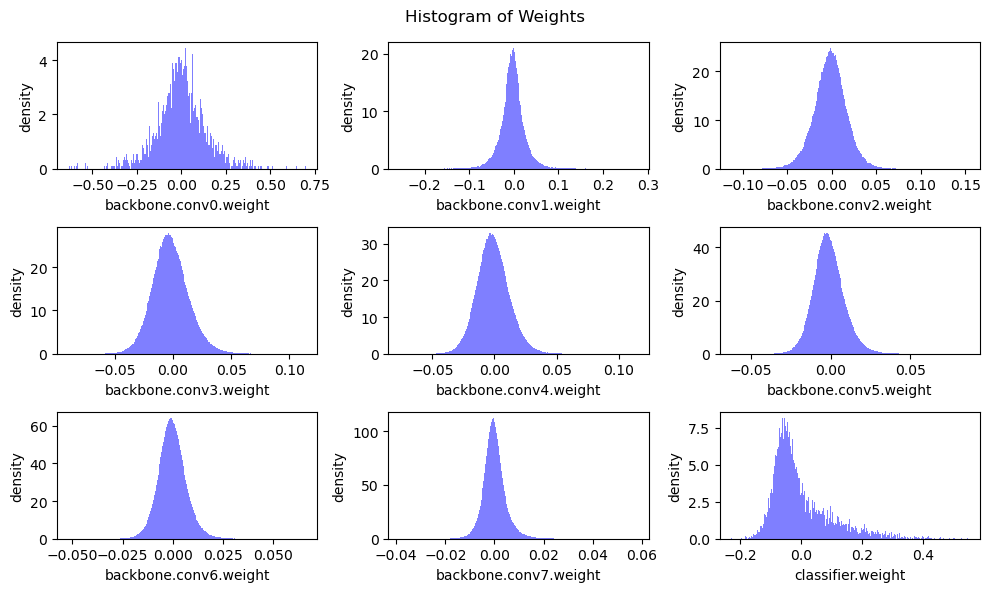

In [13]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True, color='blue', alpha=0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True, color='blue', alpha=0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

### Question 2 (15 pts)

Please complete the following magnitude-based fine-grained pruning function.

**Hint**:
*   In step 1, we calculate the number of zeros (`num_zeros`) after pruning. Note that `num_zeros` should be an integer. You could use either `round()` or `int()` to convert a floating number into an integer. Here we use `round()`.
*   In step 2, we calculate the `importance` of weight tensor. Pytorch provides [`torch.abs()`](https://pytorch.org/docs/stable/generated/torch.abs.html#torch.abs), [`torch.Tensor.abs()`](https://pytorch.org/docs/stable/generated/torch.Tensor.abs.html#torch.Tensor.abs), [`torch.Tensor.abs_()`](https://pytorch.org/docs/stable/generated/torch.Tensor.abs_.html) APIs.
*   In step 3, we calculate the pruning `threshold` so that all synapses with importance smaller than `threshold` will be removed. Pytorch provides [`torch.kthvalue()`](https://pytorch.org/docs/stable/generated/torch.kthvalue.html), [`torch.Tensor.kthvalue()`](https://pytorch.org/docs/stable/generated/torch.Tensor.kthvalue.html), [`torch.topk()`](https://pytorch.org/docs/stable/generated/torch.topk.html) APIs.
*   In step 4, we calculate the pruning `mask` based on the `threshold`. **1** in the `mask` indicates the synapse will be kept, and **0** in the `mask` indicates the synapse will be removed. `mask = importance > threshold`. Pytorch provides [`torch.gt()`](https://pytorch.org/docs/stable/generated/torch.gt.html?highlight=torch%20gt#torch.gt) API.

In [25]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    ##################### YOUR CODE STARTS HERE #####################
    # Step 1: calculate the #zeros (please use round())
    num_zeros = round(tensor.numel()*sparsity)
    # Step 2: calculate the importance of weight
    importance = torch.abs(tensor)
    # Step 3: calculate the pruning threshold
    threshold = torch.kthvalue(importance.view(-1).cpu(), num_zeros).values.to(device).item() # torch.kthvalue is not supported in mps
    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    mask = (importance > threshold)
    ##################### YOUR CODE ENDS HERE #######################

    # Step 5: apply mask to prune the tensor
    print(f"debug: {tensor.device}, {mask.device}")
    tensor.mul_(mask)

    return mask

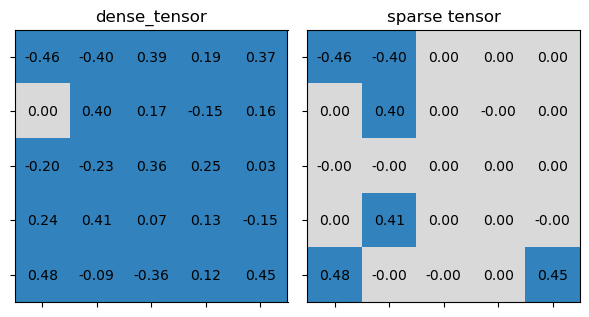

* Test fine_grained_prune()
    target sparsity: 0.75
        sparsity before pruning: 0.04
        sparsity after pruning: 0.76
        sparsity of pruning mask: 0.76
* Test passed.


In [21]:
test_fine_grained_prune()

# Q3:
The last cell plots the tensor before and after pruning. Nonzeros are rendered in blue while zeros are rendered in gray. Please modify the value of `target_sparsity` in the following code cell so that there are only 10 nonzeros in the sparse tensor after pruning.

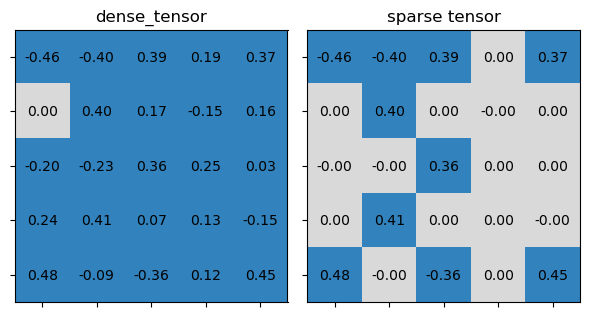

* Test fine_grained_prune()
    target sparsity: 0.60
        sparsity before pruning: 0.04
        sparsity after pruning: 0.60
        sparsity of pruning mask: 0.60
* Test passed.


In [22]:
##################### YOUR CODE STARTS HERE #####################
target_sparsity = 1- 10/(5*5) # please modify the value of target_sparsity
##################### YOUR CODE ENDS HERE #####################
test_fine_grained_prune(target_sparsity=target_sparsity, target_nonzeros=10)

We now wrap the fine-grained pruning function into a class for pruning the whole model. In class FineGrainedPruner, we have to keep a record of the pruning masks so that we could apply the masks whenever the model weights change to make sure the model keep sparse all the time.

In [23]:
import typing as t

class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGraiendPruner.prun(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict:t.Dict[str, float]):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # only for conv and FC
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks
        
    

### Sensitivity scan

Different layers contribute differently to the model performance. It is challenging to decide the proper sparsity for each layer. A widely used approach is sensitivity scan.

During the sensitivity scan, at each time, we will only prune one layer to see the accuracy degradation. By scanning different sparsities, we could draw the sensitivity curve (i.e., accuracy vs. sparsity) of the corresponding layer.

Here is an example figure for sensitivity curves. The x-axis is the sparsity or the percentage of #parameters dropped (i.e., sparsity). The y-axis is the validation accuracy. (This is Figure 6 in Learning both Weights and Connections for Efficient Neural Networks)

The following code cell defines the sensitivity scan function that returns the sparsities scanned, and a list of accuracies for each weight to be pruned.


In [26]:
@torch.no_grad()
def sensitivity_scan(model, dataloader, step=0.1, start=0.4, stop=1.0, verbose=True):
    sparsities = np.arange(start, stop, step)
    accuracies = []

    named_weights = [(name, param) for (name, param) in model.named_parameters() if param.dim() > 1]

    for i, (name, param) in enumerate(named_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i}/{len(named_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc = evaluate(model, dataloader, verbose=False)
            if verbose:
                print(f'sparsity={sparsity:.2f}: accuracy={acc:.2f}%')
            # restore weight
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies
            
    
    

In [27]:
sparsities, accuracies = sensitivity_scan(model, dataloader['test'], step=0.1, start=0.4, stop=1.0)

scanning 0/9 weight - backbone.conv0.weight:   0%|          | 0/6 [00:00<?, ?it/s]

debug: mps:0, mps:0
sparsity=0.40: accuracy=92.42%
debug: mps:0, mps:0
sparsity=0.50: accuracy=91.19%
debug: mps:0, mps:0
sparsity=0.60: accuracy=87.55%
debug: mps:0, mps:0
sparsity=0.70: accuracy=83.39%
debug: mps:0, mps:0
sparsity=0.80: accuracy=69.41%
debug: mps:0, mps:0
sparsity=0.90: accuracy=31.81%
    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.42%, 91.19%, 87.55%, 83.39%, 69.41%, 31.81%]

scanning 1/9 weight - backbone.conv1.weight:   0%|          | 0/6 [00:00<?, ?it/s]

debug: mps:0, mps:0
sparsity=0.40: accuracy=92.93%
debug: mps:0, mps:0
sparsity=0.50: accuracy=92.88%
debug: mps:0, mps:0
sparsity=0.60: accuracy=92.71%
debug: mps:0, mps:0
sparsity=0.70: accuracy=92.40%
debug: mps:0, mps:0
sparsity=0.80: accuracy=91.32%
debug: mps:0, mps:0
sparsity=0.90: accuracy=84.78%
    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.93%, 92.88%, 92.71%, 92.40%, 91.32%, 84.78%]

scanning 2/9 weight - backbone.conv2.weight:   0%|          | 0/6 [00:00<?, ?it/s]

debug: mps:0, mps:0
sparsity=0.40: accuracy=92.94%
debug: mps:0, mps:0
sparsity=0.50: accuracy=92.64%
debug: mps:0, mps:0
sparsity=0.60: accuracy=92.46%
debug: mps:0, mps:0
sparsity=0.70: accuracy=91.77%
debug: mps:0, mps:0
sparsity=0.80: accuracy=89.85%
debug: mps:0, mps:0
sparsity=0.90: accuracy=78.56%
    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.64%, 92.46%, 91.77%, 89.85%, 78.56%]

scanning 3/9 weight - backbone.conv3.weight:   0%|          | 0/6 [00:00<?, ?it/s]

debug: mps:0, mps:0
sparsity=0.40: accuracy=92.86%
debug: mps:0, mps:0
sparsity=0.50: accuracy=92.72%
debug: mps:0, mps:0
sparsity=0.60: accuracy=92.23%
debug: mps:0, mps:0
sparsity=0.70: accuracy=91.09%
debug: mps:0, mps:0
sparsity=0.80: accuracy=85.35%
debug: mps:0, mps:0
sparsity=0.90: accuracy=51.31%
    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.86%, 92.72%, 92.23%, 91.09%, 85.35%, 51.31%]

scanning 4/9 weight - backbone.conv4.weight:   0%|          | 0/6 [00:00<?, ?it/s]

debug: mps:0, mps:0
sparsity=0.40: accuracy=92.88%
debug: mps:0, mps:0
sparsity=0.50: accuracy=92.68%
debug: mps:0, mps:0
sparsity=0.60: accuracy=92.22%
debug: mps:0, mps:0
sparsity=0.70: accuracy=89.47%
debug: mps:0, mps:0
sparsity=0.80: accuracy=76.87%
debug: mps:0, mps:0
sparsity=0.90: accuracy=38.78%
    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.88%, 92.68%, 92.22%, 89.47%, 76.87%, 38.78%]

scanning 5/9 weight - backbone.conv5.weight:   0%|          | 0/6 [00:00<?, ?it/s]

debug: mps:0, mps:0
sparsity=0.40: accuracy=92.92%
debug: mps:0, mps:0
sparsity=0.50: accuracy=92.71%
debug: mps:0, mps:0
sparsity=0.60: accuracy=92.63%
debug: mps:0, mps:0
sparsity=0.70: accuracy=91.88%
debug: mps:0, mps:0
sparsity=0.80: accuracy=89.90%
debug: mps:0, mps:0
sparsity=0.90: accuracy=82.19%
    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.92%, 92.71%, 92.63%, 91.88%, 89.90%, 82.19%]

scanning 6/9 weight - backbone.conv6.weight:   0%|          | 0/6 [00:00<?, ?it/s]

debug: mps:0, mps:0
sparsity=0.40: accuracy=92.94%
debug: mps:0, mps:0
sparsity=0.50: accuracy=92.86%
debug: mps:0, mps:0
sparsity=0.60: accuracy=92.65%
debug: mps:0, mps:0
sparsity=0.70: accuracy=92.10%
debug: mps:0, mps:0
sparsity=0.80: accuracy=90.58%
debug: mps:0, mps:0
sparsity=0.90: accuracy=83.65%
    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.86%, 92.65%, 92.10%, 90.58%, 83.65%]

scanning 7/9 weight - backbone.conv7.weight:   0%|          | 0/6 [00:00<?, ?it/s]

debug: mps:0, mps:0
sparsity=0.40: accuracy=92.94%
debug: mps:0, mps:0
sparsity=0.50: accuracy=92.92%
debug: mps:0, mps:0
sparsity=0.60: accuracy=92.88%
debug: mps:0, mps:0
sparsity=0.70: accuracy=92.81%
debug: mps:0, mps:0
sparsity=0.80: accuracy=92.63%
debug: mps:0, mps:0
sparsity=0.90: accuracy=91.34%
    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.92%, 92.88%, 92.81%, 92.63%, 91.34%]

scanning 8/9 weight - classifier.weight:   0%|          | 0/6 [00:00<?, ?it/s]

debug: mps:0, mps:0
sparsity=0.40: accuracy=92.91%
debug: mps:0, mps:0
sparsity=0.50: accuracy=92.83%
debug: mps:0, mps:0
sparsity=0.60: accuracy=92.81%
debug: mps:0, mps:0
sparsity=0.70: accuracy=92.97%
debug: mps:0, mps:0
sparsity=0.80: accuracy=92.68%
debug: mps:0, mps:0
sparsity=0.90: accuracy=92.52%
    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.91%, 92.83%, 92.81%, 92.97%, 92.68%, 92.52%]

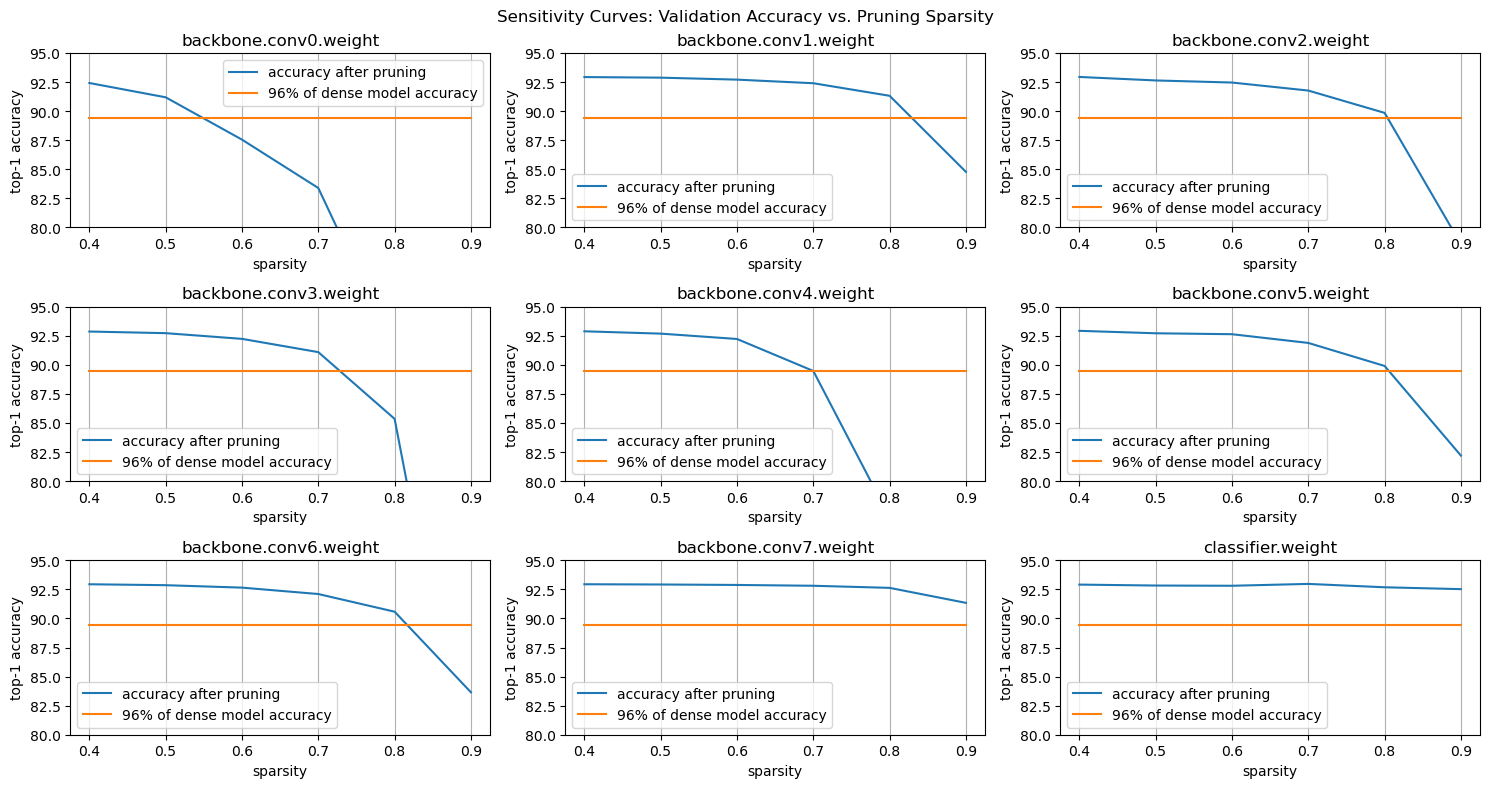

In [30]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    fig, axes = plt.subplots(3, int(math.ceil(len(accuracies) / 3)),figsize=(15,8))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
            ax.set_xticks(np.arange(start=0.4, stop=1.0, step=0.1))
            ax.set_ylim(80, 95)
            ax.set_title(name)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            ax.legend([
                'accuracy after pruning',
                f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy'
            ])
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_sensitivity_scan(sparsities, accuracies, default_model_accuracy)